In [7]:
import requests
import json

url = "http://localhost:11434/api/chat"
payload = {
    "model": "qwen3:14b",
    "messages": [{"role": "user", "content": "What is the capital of France?"}],
    "stream": False
}
response = requests.post(url, json=payload)
if response.status_code == 200:
    print(response.json()["message"]["content"])
else:
    print("Error:", response.status_code)

<think>
Okay, the user is asking for the capital of France. Let me think. I know that Paris is the capital, but I should make sure I'm not making a mistake. Wait, sometimes people confuse capitals with other major cities. For example, Berlin is the capital of Germany, and Madrid is Spain's. But France's capital is definitely Paris. Let me double-check. Yes, Paris has been the capital since the 12th century, right? It's also a major cultural and economic hub. I don't think there's any confusion here. The answer should be straightforward. Just need to confirm that there's no recent change, but I don't think so. So, the answer is Paris.
</think>

The capital of France is **Paris**. It is a major global city known for its art, culture, and historical landmarks such as the Eiffel Tower, Louvre Museum, and Notre-Dame Cathedral.


In [12]:
from openai import OpenAI

client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)

response = client.chat.completions.create(
  model="qwen2.5-coder:14b",
  messages=[
    {"role": "system", "content": "Define your self in a song of ice and fire style."}
  ],
  logitprobs=True

)
print(response.choices[0].message.content)

TypeError: Completions.create() got an unexpected keyword argument 'logitprobs'

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
model_name = "unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit"
#model_name = "Qwen/Qwen2.5-Coder-7B-Instruct"


from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",         # Hugging Face will map layers to GPU automatically
    quantization_config=bnb_config
)

c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\transformers\quantizers\auto.py:226: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.53s/it]


In [22]:
prompt = """
Introduce me to a bot from song of ice and fire
"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

output = model.generate(**inputs, 
        max_new_tokens=300, 
        return_dict_in_generate=True, 
        output_scores=True,
        do_sample=True,        # Enable sampling
        temperature=1,       # Add some randomness
        top_p=0.9,            # Nucleus sampling
        pad_token_id=tokenizer.eos_token_id
    )
logits = model(**inputs, return_dict=True).logits

print('logits',50*'=')
print(logits)


print('output',50*'=')
print(output)
print('scores',50*'=')
print(output.scores)
print('response',50*'=')
result = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
print(result)

logits ==================================================
tensor([[[ 4.1797,  4.0586,  4.0234,  ..., -2.9766, -2.9766, -2.9766],
         [ 6.2617,  5.5391,  7.2773,  ...,  1.1543,  1.1543,  1.1543],
         [ 6.9102,  5.0625,  4.6523,  ...,  0.2798,  0.2798,  0.2798],
         ...,
         [ 5.1250,  4.4648,  2.1953,  ..., -4.1914, -4.1914, -4.1914],
         [10.4531,  4.9414,  4.3242,  ..., -2.2578, -2.2578, -2.2578],
         [ 5.2891,  8.9141,  8.1328,  ..., -3.1406, -3.1406, -3.1406]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnsafeViewBackward0>)
output ==================================================
GenerateDecoderOnlyOutput(sequences=tensor([[   198,   1072,  47845,    752,    311,    264,  10924,    504,   5492,
            315,   9853,    323,   3940,    198,   3862,    525,   1657,  49529,
            323,   6236,  61905,    429,    614,   1012,   3465,   3118,    389,
            279,   5766,    323,   3364,   7969,    315,   9857,    431,   2013,
      

In [23]:
# Get the first generated token ID directly
original_length = inputs['input_ids'].shape[1]
print(original_length)
token_id = output.sequences[0][original_length]
token_text = tokenizer.decode([token_id])
probs = F.softmax(output.scores[0][0], dim=-1)

print(f"'{token_text}' -> {probs[token_id]:.4f}")

14
'There' -> 0.1381


In [24]:
original_length = inputs['input_ids'].shape[1]
for i in range(len(output.scores)):
    new_token_id = output.sequences[0][original_length + i]
    prob = F.softmax(output.scores[i][0], dim=-1)[new_token_id].item()
    text = tokenizer.decode([new_token_id])
    print(f"New token ID: {i}, Probability: {prob:.4f}, Text: {text}")
print(original_length)



New token ID: 0, Probability: 0.1381, Text: There
New token ID: 1, Probability: 0.5215, Text:  are
New token ID: 2, Probability: 0.0922, Text:  many
New token ID: 3, Probability: 0.3804, Text:  bots
New token ID: 4, Probability: 0.3986, Text:  and
New token ID: 5, Probability: 0.0441, Text:  chat
New token ID: 6, Probability: 1.0000, Text: bots
New token ID: 7, Probability: 0.6306, Text:  that
New token ID: 8, Probability: 0.6252, Text:  have
New token ID: 9, Probability: 1.0000, Text:  been
New token ID: 10, Probability: 0.5813, Text:  created
New token ID: 11, Probability: 0.9437, Text:  based
New token ID: 12, Probability: 1.0000, Text:  on
New token ID: 13, Probability: 0.8652, Text:  the
New token ID: 14, Probability: 0.4264, Text:  characters
New token ID: 15, Probability: 0.8918, Text:  and
New token ID: 16, Probability: 0.1977, Text:  story
New token ID: 17, Probability: 1.0000, Text: lines
New token ID: 18, Probability: 0.7064, Text:  of
New token ID: 19, Probability: 0.2781, 

In [25]:



def mean_entropy_per_token1(output):
    """Calculate mean entropy per token using FULL probability distribution"""
    entropies = []
    
    for i in range(len(output.scores)):
        # Get FULL probability distribution for this step
        logits = output.scores[i][0]
        probs = F.softmax(logits, dim=-1)
        
        # Calculate entropy over ALL tokens in vocabulary
        entropy = -(probs * torch.log(probs + 1e-8)).sum()
        entropies.append(entropy)
    
    return sum(entropies) / len(entropies) if entropies else 0

print(mean_entropy_per_token1(output))

tensor(0.3676, device='cuda:0')


In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
import ast
import re

# Your uncertainty functions
def mean_entropy_per_token(output):
    """Calculate mean entropy per token using FULL probability distribution"""
    entropies = []
    
    for i in range(len(output.scores)):
        logits = output.scores[i][0]
        probs = F.softmax(logits, dim=-1)
        entropy = -(probs * torch.log(probs + 1e-8)).sum()
        entropies.append(entropy)
    
    return sum(entropies) / len(entropies) if entropies else 0

def sequence_length(output):
    """Get the length of generated sequence"""
    return len(output.scores)

# Test execution function
def execute_code_with_tests(code, entry_point, testcase):
    """Execute code and check if it passes all test cases"""
    try:
        # Create namespace and execute the code
        namespace = {}
        exec(code, namespace)
        
        # Parse test cases - handle the string format
        if isinstance(testcase, str):
            # Remove the outer brackets and split by comma, but be careful with nested structures
            testcase = testcase.strip('[]')
            # This is a simple approach - you might need more sophisticated parsing
            test_cases = [testcase]  # For now, treat as single test
            
            # Try to split properly
            try:
                # Look for assert statements
                test_cases = []
                current_test = ""
                paren_count = 0
                
                i = 0
                while i < len(testcase):
                    char = testcase[i]
                    current_test += char
                    
                    if char == '(':
                        paren_count += 1
                    elif char == ')':
                        paren_count -= 1
                    elif char == ',' and paren_count == 0:
                        if current_test.strip():
                            test_cases.append(current_test.rstrip(',').strip())
                            current_test = ""
                    
                    i += 1
                
                # Add the last test
                if current_test.strip():
                    test_cases.append(current_test.strip())
                    
            except:
                # Fallback to simple approach
                test_cases = [testcase]
        
        # Run all test cases
        for test in test_cases:
            test = test.strip()
            if test.startswith('assert'):
                try:
                    exec(test, namespace)
                except AssertionError:
                    return False  # Test failed
                except Exception as e:
                    print(f"Test execution error: {e}")
                    return False
        
        return True  # All tests passed
    
    except Exception as e:
        print(f"Code execution error: {e}")
        return False

def extract_code_from_response(response):
    """Extract Python code from model response"""
    # Look for code blocks
    if "```python" in response:
        start = response.find("```python") + 9
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    # Look for any ``` blocks
    if "```" in response:
        start = response.find("```") + 3
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    # Look for def functions
    lines = response.split('\n')
    code_lines = []
    in_function = False
    
    for line in lines:
        if line.strip().startswith('def '):
            in_function = True
        if in_function:
            code_lines.append(line)
    
    return '\n'.join(code_lines).strip() if code_lines else response.strip()

def process_dataset_with_model(csv_path, model, tokenizer, save_path="router_dataset.csv", batch_size=5):
    """
    Process the entire dataset in batches:
    1. Load CSV
    2. Generate code for each problem (in batches)
    3. Test the code
    4. Extract uncertainty features
    5. Create labels and save enhanced dataset
    """
    
    # Load dataset
    print("Loading dataset...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} problems")
    
    # Results storage
    results = []
    
    # Process in batches to manage memory
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        print(f"\n--- Processing Batch {batch_idx + 1}/{total_batches} (Problems {start_idx+1}-{end_idx}) ---")
        
        # Clear cache before each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        for idx, row in batch_df.iterrows():
            print(f"\nProcessing {idx+1}/{len(df)}: {row['seq_id']}")
            
            try:
                # Prepare prompt for your model
                instruction = row['instruction']
                prompt = f"Write a Python function for this problem:\n{instruction}"
                
                # Tokenize and move to same device as model
                inputs = tokenizer(prompt, return_tensors="pt")
                
                # Move inputs to GPU (same device as model)
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Generate with your current settings
                with torch.no_grad():  # Add this to save memory
                    output = model.generate(
                        **inputs,
                        max_new_tokens=200,  # Reduced from 300
                        return_dict_in_generate=True,
                        output_scores=True,
                        do_sample=True,
                        temperature=1,
                        top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id
                    )
                
                # Extract generated text
                generated_text = tokenizer.decode(
                    output.sequences[0][inputs['input_ids'].shape[1]:], 
                    skip_special_tokens=True
                )
                
                print(f"Generated: {generated_text[:100]}...")
                
                # Extract code from response
                generated_code = extract_code_from_response(generated_text)
                
                if not generated_code:
                    print("Warning: No code extracted")
                    generated_code = generated_text  # Use full response as fallback
                
                # Calculate uncertainty metrics using your functions
                mean_entropy = float(mean_entropy_per_token(output))
                seq_length = sequence_length(output)
                
                print(f"Mean entropy: {mean_entropy:.4f}, Sequence length: {seq_length}")
                
                # Test the generated code
                passes_tests = execute_code_with_tests(
                    generated_code,
                    row['entry_point'],
                    row['testcase']
                )
                
                # Create label: 0 = small model sufficient, 1 = need large model
                label = 0 if passes_tests else 1
                
                print(f"Tests passed: {passes_tests}, Label: {label}")
                
                # Store results
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'generated_code': generated_code,
                    'generated_text': generated_text,
                    'passes_tests': passes_tests,
                    'label': label,
                    'mean_entropy': mean_entropy,
                    'sequence_length': seq_length
                }
                
                results.append(result)
                
                # Clear variables to free memory
                del output, inputs, generated_text
                
            except Exception as e:
                print(f"Error processing {row['seq_id']}: {e}")
                
                # Add failed entry with defaults
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'generated_code': '',
                    'generated_text': '',
                    'passes_tests': False,
                    'label': 1,  # Assume need large model if failed
                    'mean_entropy': 0.0,
                    'sequence_length': 0
                }
                results.append(result)
                continue
            
            finally:
                # Always clear cache after each generation
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        # Save progress after each batch
        if results:
            temp_df = pd.DataFrame(results)
            temp_save_path = save_path.replace('.csv', f'_batch_{batch_idx+1}.csv')
            temp_df.to_csv(temp_save_path, index=False)
            print(f"Batch {batch_idx+1} saved to {temp_save_path}")
    
    # Convert to DataFrame and save final results
    enhanced_df = pd.DataFrame(results)
    enhanced_df.to_csv(save_path, index=False)
    
    print(f"\nDataset processed and saved to {save_path}")
    print(f"Results summary:")
    print(f"- Total problems: {len(enhanced_df)}")
    print(f"- Tests passed (label=0): {sum(enhanced_df['label'] == 0)}")
    print(f"- Tests failed (label=1): {sum(enhanced_df['label'] == 1)}")
    if len(enhanced_df) > 0:
        print(f"- Mean entropy range: {enhanced_df['mean_entropy'].min():.4f} - {enhanced_df['mean_entropy'].max():.4f}")
        print(f"- Sequence length range: {enhanced_df['sequence_length'].min()} - {enhanced_df['sequence_length'].max()}")
    
    return enhanced_df

# Usage example
if __name__ == "__main__":
    
    # Your model setup goes here
    # model = your_model
    # tokenizer = your_tokenizer
    
    # Process the dataset
    enhanced_dataset = process_dataset_with_model(
        csv_path="C:/Users/s/Desktop/Dev/SamsungProject/extract/top-30-educational-instruct-rows.csv",
        model=model,  # Pass the actual model object, not model_name
        tokenizer=tokenizer,
        save_path="enhanced_router_dataset.csv"
    )
    
    # Quick analysis
    print("\nQuick Analysis:")
    print(enhanced_dataset[['seq_id', 'passes_tests', 'label', 'mean_entropy', 'sequence_length']].head(10))

NameError: name 'model' is not defined

Data loaded!
Shape: (18, 13)
Columns: ['seq_id', 'instruction', 'output', 'code', 'entry_point', 'testcase', 'formatted_prompt', 'generated_code', 'generated_text', 'passes_tests', 'label', 'mean_entropy', 'sequence_length']



C:\Users\s\AppData\Local\Temp\ipykernel_12820\2081830749.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='result', y='mean_entropy', palette='coolwarm')
C:\Users\s\AppData\Local\Temp\ipykernel_12820\2081830749.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='result', y='sequence_length', palette='viridis')
c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


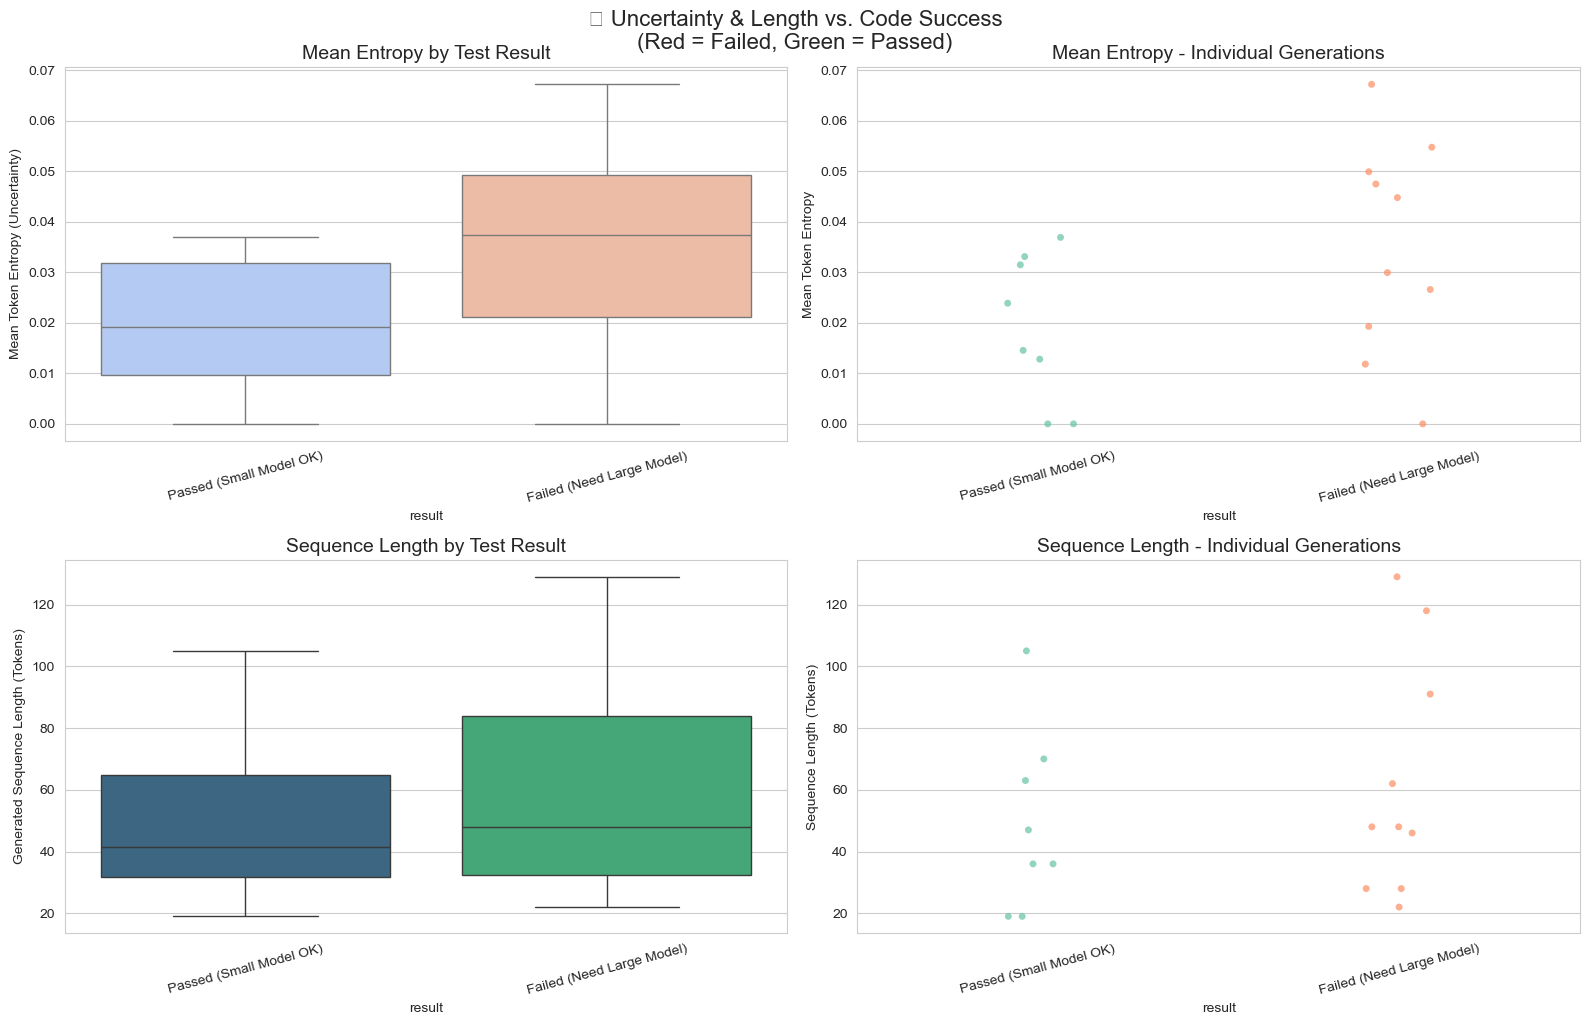

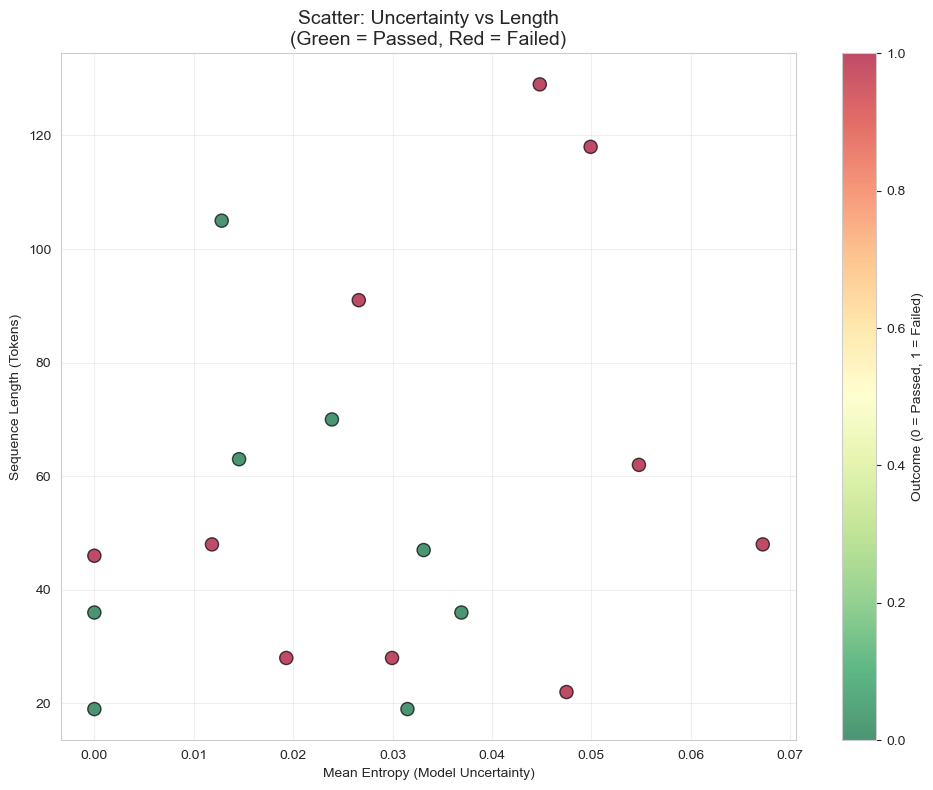

: 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === LOAD YOUR DATA ===
# Update path if needed, or keep as is if file is in current directory
df = pd.read_csv("enhanced_router_dataset_batch_6.csv")

# Display basic info
print("Data loaded!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}\n")

# Check if required columns exist
required_cols = ['mean_entropy', 'sequence_length', 'label', 'passes_tests']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Drop rows with missing values in key columns
df.dropna(subset=required_cols, inplace=True)

# Map label to readable success/failure
df['result'] = df['label'].map({0: 'Passed (Small Model OK)', 1: 'Failed (Need Large Model)'})

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(16, 10))

# === 1. Mean Entropy: Box Plot ===
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='result', y='mean_entropy', palette='coolwarm')
plt.title('Mean Entropy by Test Result', fontsize=14)
plt.ylabel('Mean Token Entropy (Uncertainty)')
plt.xticks(rotation=15)

# === 2. Mean Entropy: Strip Plot (Individual Samples) ===
plt.subplot(2, 2, 2)
sns.stripplot(data=df, x='result', y='mean_entropy', hue='result', palette='Set2', alpha=0.7, legend=False)
plt.title('Mean Entropy - Individual Generations', fontsize=14)
plt.ylabel('Mean Token Entropy')
plt.xticks(rotation=15)

# === 3. Sequence Length: Box Plot ===
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='result', y='sequence_length', palette='viridis')
plt.title('Sequence Length by Test Result', fontsize=14)
plt.ylabel('Generated Sequence Length (Tokens)')
plt.xticks(rotation=15)

# === 4. Sequence Length: Strip Plot ===
plt.subplot(2, 2, 4)
sns.stripplot(data=df, x='result', y='sequence_length', hue='result', palette='Set2', alpha=0.7, legend=False)
plt.title('Sequence Length - Individual Generations', fontsize=14)
plt.ylabel('Sequence Length (Tokens)')
plt.xticks(rotation=15)

# Finalize layout
plt.tight_layout()
plt.suptitle("📊 Uncertainty & Length vs. Code Success\n(Red = Failed, Green = Passed)", fontsize=16, y=1.02)
plt.show()

# === SCATTER PLOT: Entropy vs Length, colored by Outcome ===
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df['mean_entropy'],
    df['sequence_length'],
    c=df['label'], cmap='RdYlGn_r', alpha=0.7, edgecolor='k', s=90
)
plt.colorbar(scatter, label='Outcome (0 = Passed, 1 = Failed)')
plt.xlabel('Mean Entropy (Model Uncertainty)')
plt.ylabel('Sequence Length (Tokens)')
plt.title('Scatter: Uncertainty vs Length\n(Green = Passed, Red = Failed)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === HISTOGRAMS: Distribution of Features by Label ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograms
for label_val, color, label_name in zip([0, 1], ['green', 'red'], ['Passed', 'Failed']):
    subset = df[df['label'] == label_val]
    # Mean Entropy
    axes[0, 0].hist(subset['mean_entropy'], bins=15, alpha=0.6, color=color, label=label_name, edgecolor='black')
    # Sequence Length
    axes[0, 1].hist(subset['sequence_length'], bins=15, alpha=0.6, color=color, label=label_name, edgecolor='black')

axes[0, 0].set_xlabel('Mean Entropy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Mean Entropy')
axes[0, 0].legend()

axes[0, 1].set_xlabel('Sequence Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Sequence Length')
axes[0, 1].legend()

# Summary Stats Table
axes[1, 0].axis('off')
summary_text = (
    f"Total Problems: {len(df)}\n"
    f"Passed (label=0): {sum(df['label']==0)}\n"
    f"Failed (label=1): {sum(df['label']==1)}\n"
    f"\nMean Entropy:\n"
    f"  Passed:  {df[df['label']==0]['mean_entropy'].mean():.3f}\n"
    f"  Failed:  {df[df['label']==1]['mean_entropy'].mean():.3f}\n"
    f"\nSequence Length:\n"
    f"  Passed:  {df[df['label']==0]['sequence_length'].mean():.1f}\n"
    f"  Failed:  {df[df['label']==1]['sequence_length'].mean():.1f}"
)
axes[1, 0].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

# Optional: Correlation
corr_entropy = df['mean_entropy'].corr(df['label'])
corr_length = df['sequence_length'].corr(df['label'])
axes[1, 1].axis('off')
corr_text = (
    f"Correlation with Label (1 = Failure):\n\n"
    f"Mean Entropy  ↔  Label:  {corr_entropy:+.3f}\n\n"
    f"Sequence Length  ↔  Label:  {corr_length:+.3f}\n\n"
    f"→ Positive correlation means higher feature → more likely to fail"
)
axes[1, 1].text(0.1, 0.5, corr_text, fontsize=12, verticalalignment='center', bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))

plt.suptitle("📊 Summary Statistics & Correlations", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
import ast
import re

# Your uncertainty functions
def mean_entropy_per_token(output):
    """Calculate mean entropy per token using FULL probability distribution"""
    entropies = []
    
    for i in range(len(output.scores)):
        logits = output.scores[i][0]
        probs = F.softmax(logits, dim=-1)
        entropy = -(probs * torch.log(probs + 1e-8)).sum()
        entropies.append(entropy)
    
    return sum(entropies) / len(entropies) if entropies else 0

def sequence_length(output):
    """Get the length of generated sequence"""
    return len(output.scores)

# Test execution function
def execute_code_with_tests(code, entry_point, testcase):
    """Execute code and check if it passes all test cases"""
    try:
        # Create namespace and execute the code
        namespace = {}
        exec(code, namespace)
        
        # Parse test cases - handle the string format
        if isinstance(testcase, str):
            # Remove the outer brackets and split by comma, but be careful with nested structures
            testcase = testcase.strip('[]')
            # This is a simple approach - you might need more sophisticated parsing
            test_cases = [testcase]  # For now, treat as single test
            
            # Try to split properly
            try:
                # Look for assert statements
                test_cases = []
                current_test = ""
                paren_count = 0
                
                i = 0
                while i < len(testcase):
                    char = testcase[i]
                    current_test += char
                    
                    if char == '(':
                        paren_count += 1
                    elif char == ')':
                        paren_count -= 1
                    elif char == ',' and paren_count == 0:
                        if current_test.strip():
                            test_cases.append(current_test.rstrip(',').strip())
                            current_test = ""
                    
                    i += 1
                
                # Add the last test
                if current_test.strip():
                    test_cases.append(current_test.strip())
                    
            except:
                # Fallback to simple approach
                test_cases = [testcase]
        
        # Run all test cases
        for test in test_cases:
            test = test.strip()
            if test.startswith('assert'):
                try:
                    exec(test, namespace)
                except AssertionError:
                    return False  # Test failed
                except Exception as e:
                    print(f"Test execution error: {e}")
                    return False
        
        return True  # All tests passed
    
    except Exception as e:
        print(f"Code execution error: {e}")
        return False

def extract_code_from_response(response):
    """Extract Python code from model response"""
    # Look for code blocks
    if "```python" in response:
        start = response.find("```python") + 9
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    # Look for any ``` blocks
    if "```" in response:
        start = response.find("```") + 3
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    # Look for def functions
    lines = response.split('\n')
    code_lines = []
    in_function = False
    
    for line in lines:
        if line.strip().startswith('def '):
            in_function = True
        if in_function:
            code_lines.append(line)
    
    return '\n'.join(code_lines).strip() if code_lines else response.strip()

def create_qwen_prompt(instruction):
    """Create a structured prompt for Qwen model with clear instructions"""
    return [
        {
            "role": "system",
            "content": "You are a skilled Python programmer. Write clean, working code without comments or explanations. Focus only on solving the problem correctly."
        },
        {
            "role": "user", 
            "content": f"Write a Python function to solve this problem. Provide only the function code without comments or explanations:\n\n{instruction}"
        }
    ]

def process_dataset_with_model(csv_path, model, tokenizer, save_path="router_dataset.csv", batch_size=5):
    """
    Process the entire dataset in batches:
    1. Load CSV
    2. Generate code for each problem (in batches) using Qwen chat template
    3. Test the code
    4. Extract uncertainty features
    5. Create labels and save enhanced dataset
    """
    
    # Load dataset
    print("Loading dataset...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} problems")
    
    # Results storage
    results = []
    
    # Process in batches to manage memory
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        print(f"\n--- Processing Batch {batch_idx + 1}/{total_batches} (Problems {start_idx+1}-{end_idx}) ---")
        
        # Clear cache before each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        for idx, row in batch_df.iterrows():
            print(f"\nProcessing {idx+1}/{len(df)}: {row['seq_id']}")
            
            try:
                # Create structured prompt using Qwen's chat format
                messages = create_qwen_prompt(row['instruction'])
                
                # Apply Qwen's chat template
                prompt = tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )
                
                print(f"Formatted prompt: {prompt[:200]}...")
                
                # Tokenize and move to same device as model
                inputs = tokenizer(prompt, return_tensors="pt")
                
                # Move inputs to GPU (same device as model)
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Generate with your current settings
                with torch.no_grad():  # Add this to save memory
                    output = model.generate(
                        **inputs,
                        max_new_tokens=200,  # Reduced from 300
                        return_dict_in_generate=True,
                        output_scores=True,
                        do_sample=True,
                        temperature=0.7,  # Slightly lower for more focused code
                        top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id
                    )
                
                # Extract generated text
                generated_text = tokenizer.decode(
                    output.sequences[0][inputs['input_ids'].shape[1]:], 
                    skip_special_tokens=True
                )
                
                print(f"Generated: {generated_text[:100]}...")
                
                # Extract code from response
                generated_code = extract_code_from_response(generated_text)
                
                if not generated_code:
                    print("Warning: No code extracted")
                    generated_code = generated_text  # Use full response as fallback
                
                # Calculate uncertainty metrics using your functions
                mean_entropy = float(mean_entropy_per_token(output))
                seq_length = sequence_length(output)
                
                print(f"Mean entropy: {mean_entropy:.4f}, Sequence length: {seq_length}")
                
                # Test the generated code
                passes_tests = execute_code_with_tests(
                    generated_code,
                    row['entry_point'],
                    row['testcase']
                )
                
                # Create label: 0 = small model sufficient, 1 = need large model
                label = 0 if passes_tests else 1
                
                print(f"Tests passed: {passes_tests}, Label: {label}")
                
                # Store results
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': prompt,
                    'generated_code': generated_code,
                    'generated_text': generated_text,
                    'passes_tests': passes_tests,
                    'label': label,
                    'mean_entropy': mean_entropy,
                    'sequence_length': seq_length
                }
                
                results.append(result)
                
                # Clear variables to free memory
                del output, inputs, generated_text
                
            except Exception as e:
                print(f"Error processing {row['seq_id']}: {e}")
                
                # Add failed entry with defaults
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': '',
                    'generated_code': '',
                    'generated_text': '',
                    'passes_tests': False,
                    'label': 1,  # Assume need large model if failed
                    'mean_entropy': 0.0,
                    'sequence_length': 0
                }
                results.append(result)
                continue
            
            finally:
                # Always clear cache after each generation
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        # Save progress after each batch
        if results:
            temp_df = pd.DataFrame(results)
            temp_save_path = save_path.replace('.csv', f'_batch_{batch_idx+1}.csv')
            temp_df.to_csv(temp_save_path, index=False)
            print(f"Batch {batch_idx+1} saved to {temp_save_path}")
    
    # Convert to DataFrame and save final results
    enhanced_df = pd.DataFrame(results)
    enhanced_df.to_csv(save_path, index=False)
    
    print(f"\nDataset processed and saved to {save_path}")
    print(f"Results summary:")
    print(f"- Total problems: {len(enhanced_df)}")
    print(f"- Tests passed (label=0): {sum(enhanced_df['label'] == 0)}")
    print(f"- Tests failed (label=1): {sum(enhanced_df['label'] == 1)}")
    if len(enhanced_df) > 0:
        print(f"- Mean entropy range: {enhanced_df['mean_entropy'].min():.4f} - {enhanced_df['mean_entropy'].max():.4f}")
        print(f"- Sequence length range: {enhanced_df['sequence_length'].min()} - {enhanced_df['sequence_length'].max()}")
        print(f"- Pass rate: {(sum(enhanced_df['label'] == 0) / len(enhanced_df) * 100):.1f}%")
    
    return enhanced_df


if __name__ == "__main__":
    import torch
    import torch.nn.functional as F
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch

    model_name = "unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit"
#model_name = "Qwen/Qwen2.5-Coder-7B-Instruct"


    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",         # Hugging Face will map layers to GPU automatically
    quantization_config=bnb_config
    )
    # Your model setup goes here
    # model = your_model
    # tokenizer = your_tokenizer
    
    # Process the dataset
    enhanced_dataset = process_dataset_with_model(
        csv_path="C:/Users/s/Desktop/Dev/SamsungProject/extract/top-30-educational-instruct-rows.csv",
        model=model,  # Pass the actual model object, not model_name
        tokenizer=tokenizer,
        save_path="enhanced_router_dataset.csv",
        batch_size=3  # Reduced batch size for better memory management
    )
    
    # Quick analysis
    print("\nQuick Analysis:")
    print(enhanced_dataset[['seq_id', 'passes_tests', 'label', 'mean_entropy', 'sequence_length']].head(10))


c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\transformers\quantizers\auto.py:226: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.86s/it]


Loading dataset...
Loaded 30 problems

--- Processing Batch 1/10 (Problems 1-3) ---

Processing 1/30: 660113403
Formatted prompt: <|im_start|>system
You are a skilled Python programmer. Write clean, working code without comments or explanations. Focus only on solving the problem correctly.<|im_end|>
<|im_start|>user
Write a Pyth...
Generated: ```python
def is_palindrome(s):
    s = ''.join(c.lower() for c in s if c.isalnum())
    return s ==...
Mean entropy: 0.0000, Sequence length: 36
Tests passed: True, Label: 0

Processing 2/30: 14192481277
Formatted prompt: <|im_start|>system
You are a skilled Python programmer. Write clean, working code without comments or explanations. Focus only on solving the problem correctly.<|im_end|>
<|im_start|>user
Write a Pyth...
Generated: ```python
def find_missing_number(nums):
    n = len(nums)
    expected_sum = n * (n + 1) // 2
    a...
Mean entropy: 0.0118, Sequence length: 48
Test execution error: name 'missing_number' is not defined
Tests passed

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
from typing import Dict, List, Any

def extract_comprehensive_uncertainty_features(output, tokenizer) -> Dict[str, float]:
    """
    Extract richer uncertainty and confidence features from model output.
    Includes residual mass, top-1 vs top-2 margin, variance, and extreme values.
    """
    features = {}
    
    if not hasattr(output, 'scores') or not output.scores:
        return {f: 0.0 for f in get_feature_names()}
    
    # Convert scores to tensors and probabilities
    logits_list = [score[0] for score in output.scores]  # (batch=1 removed)
    probs_list = [F.softmax(logits, dim=-1) for logits in logits_list]
    
    # -------------------------------------------------------------------------
    # 1. ENTROPY FEATURES
    # -------------------------------------------------------------------------
    entropies = [-(probs * torch.log(probs + 1e-8)).sum().item() for probs in probs_list]
    features['mean_entropy'] = float(np.mean(entropies))
    features['max_entropy'] = float(np.max(entropies))
    features['min_entropy'] = float(np.min(entropies))
    features['std_entropy'] = float(np.std(entropies))
    
    # -------------------------------------------------------------------------
    # 2. PROBABILITY FEATURES
    # -------------------------------------------------------------------------
    max_probs = [torch.max(probs).item() for probs in probs_list]
    features['mean_max_prob'] = float(np.mean(max_probs))
    features['min_max_prob'] = float(np.min(max_probs))
    features['std_max_prob'] = float(np.std(max_probs))
    
    max_possible_entropy = torch.log(torch.tensor(probs_list[0].shape[-1])).item()
    confidences = [1 - (ent / max_possible_entropy) for ent in entropies]
    features['mean_confidence'] = float(np.mean(confidences))
    features['min_confidence'] = float(np.min(confidences))
    
    # -------------------------------------------------------------------------
    # 3. TOP-K FEATURES (fixed to avoid collapse)
    # -------------------------------------------------------------------------
    top2_ratios, margins, residual5, residual10 = [], [], [], []
    
    for probs in probs_list:
        sorted_probs, _ = torch.sort(probs, descending=True)
        
        # Top-2 ratio
        if len(sorted_probs) >= 2:
            top2_ratios.append((sorted_probs[0] / (sorted_probs[1] + 1e-8)).item())
            margins.append((sorted_probs[0] - sorted_probs[1]).item())
        
        # Residual mass after top-k
        residual5.append((1.0 - sorted_probs[:5].sum()).item())
        residual10.append((1.0 - sorted_probs[:10].sum()).item())
    
    features['mean_top2_ratio'] = float(np.mean(top2_ratios)) if top2_ratios else 0.0
    features['mean_margin'] = float(np.mean(margins)) if margins else 0.0
    features['residual_top5'] = float(np.mean(residual5))
    features['residual_top10'] = float(np.mean(residual10))
    
    # -------------------------------------------------------------------------
    # 4. SEQUENCE FEATURES
    # -------------------------------------------------------------------------
    features['sequence_length'] = len(output.scores)
    features['prob_variance'] = float(np.var(max_probs))
    features['entropy_variance'] = float(np.var(entropies))
    features['entropy_range'] = float(np.max(entropies) - np.min(entropies))
    
    # Perplexity (use mean entropy directly, not max_prob hack)
    features['perplexity'] = float(np.exp(features['mean_entropy']))
    
    # -------------------------------------------------------------------------
    # 5. SHARPNESS FEATURE (Gini)
    # -------------------------------------------------------------------------
    sharpness_scores = []
    for probs in probs_list:
        sorted_probs = torch.sort(probs, descending=True)[0]
        n = len(sorted_probs)
        index = torch.arange(1, n + 1, dtype=torch.float32, device=probs.device)
        gini = (2 * torch.sum(index * sorted_probs)) / (n * torch.sum(sorted_probs)) - (n + 1) / n
        sharpness_scores.append(gini.item())
    features['mean_sharpness'] = float(np.mean(sharpness_scores))
    
    # -------------------------------------------------------------------------
    # 6. CODE STRUCTURE FEATURES (unchanged)
    # -------------------------------------------------------------------------
    if hasattr(output, 'sequences'):
        generated_tokens = output.sequences[0]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        features['has_syntax_keywords'] = float(any(keyword in generated_text.lower() 
                                                   for keyword in ['def', 'class', 'if', 'for', 'while', 'return']))
        features['has_parentheses'] = float('(' in generated_text and ')' in generated_text)
        features['has_brackets'] = float('[' in generated_text and ']' in generated_text)
        features['has_braces'] = float('{' in generated_text and '}' in generated_text)
        features['indentation_consistency'] = calculate_indentation_consistency(generated_text)
        
        words = generated_text.split()
        features['word_repetition_ratio'] = 1.0 - (len(set(words)) / len(words)) if words else 0.0
    else:
        features.update({
            'has_syntax_keywords': 0.0,
            'has_parentheses': 0.0,
            'has_brackets': 0.0,
            'has_braces': 0.0,
            'indentation_consistency': 0.0,
            'word_repetition_ratio': 0.0,
        })
    
    # -------------------------------------------------------------------------
    # Placeholders for attention
    # -------------------------------------------------------------------------
    features['attention_entropy'] = 0.0
    features['attention_variance'] = 0.0
    
    return features

def calculate_indentation_consistency(text: str) -> float:
    """Calculate consistency of indentation in generated code"""
    lines = text.split('\n')
    indentations = []
    
    for line in lines:
        if line.strip():  # Non-empty lines
            indent = len(line) - len(line.lstrip())
            indentations.append(indent)
    
    if len(indentations) < 2:
        return 1.0
    
    # Check if indentations follow a pattern (multiples of 2 or 4)
    if all(indent % 4 == 0 for indent in indentations):
        return 1.0
    elif all(indent % 2 == 0 for indent in indentations):
        return 0.8
    else:
        return 0.5

def get_feature_names() -> List[str]:
    """Return list of all feature names for consistent ordering"""
    return [
        # Entropy features
        'mean_entropy', 'max_entropy', 'min_entropy', 'std_entropy',
        # Probability features  
        'mean_max_prob', 'min_max_prob', 'std_max_prob',
        'mean_confidence', 'min_confidence',
        # Top-k features
        'mean_top2_ratio', 'mean_top5_sum', 'mean_top10_sum',
        # Sequence features
        'sequence_length', 'perplexity', 'prob_variance', 'mean_sharpness',
        # Linguistic features
        'has_syntax_keywords', 'has_parentheses', 'has_brackets', 'has_braces',
        'indentation_consistency', 'word_repetition_ratio',
        # Attention features (placeholders)
        'attention_entropy', 'attention_variance'
    ]

# =============================================================================
# UPDATED PROCESSING FUNCTION
# =============================================================================

def process_dataset_with_enhanced_features(csv_path, model, tokenizer, save_path="enhanced_router_dataset.csv", batch_size=3):
    """
    Updated version of your processing function with comprehensive feature extraction
    """
    print("Loading dataset...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} problems")
    
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        print(f"\n--- Processing Batch {batch_idx + 1}/{total_batches} (Problems {start_idx+1}-{end_idx}) ---")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        for idx, row in batch_df.iterrows():
            print(f"\nProcessing {idx+1}/{len(df)}: {row['seq_id']}")
            
            try:
                # Create structured prompt using Qwen's chat format
                messages = [
                    {
                        "role": "system",
                        "content": "You are a skilled Python programmer. Write clean, working code without comments or explanations. Focus only on solving the problem correctly."
                    },
                    {
                        "role": "user", 
                        "content": f"Write a Python function to solve this problem. Provide only the function code without comments or explanations:\n\n{row['instruction']}"
                    }
                ]
                
                prompt = tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )
                
                inputs = tokenizer(prompt, return_tensors="pt")
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Generate with scores for uncertainty analysis
                with torch.no_grad():
                    output = model.generate(
                        **inputs,
                        max_new_tokens=200,
                        return_dict_in_generate=True,
                        output_scores=True,
                        do_sample=True,
                        temperature=0.7,
                        top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id
                    )
                
                # Extract generated text
                generated_text = tokenizer.decode(
                    output.sequences[0][inputs['input_ids'].shape[1]:], 
                    skip_special_tokens=True
                )
                
                # Extract comprehensive features
                uncertainty_features = extract_comprehensive_uncertainty_features(output, tokenizer)
                
                print(f"Generated: {generated_text[:100]}...")
                print(f"Features extracted: {len(uncertainty_features)} features")
                
                # Extract code and test it
                generated_code = extract_code_from_response(generated_text)
                
                if not generated_code:
                    generated_code = generated_text
                
                # Test the generated code
                passes_tests = execute_code_with_tests(
                    generated_code,
                    row['entry_point'],
                    row['testcase']
                )
                
                label = 0 if passes_tests else 1
                print(f"Tests passed: {passes_tests}, Label: {label}")
                
                # Store results with all features
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': prompt,
                    'generated_code': generated_code,
                    'generated_text': generated_text,
                    'passes_tests': passes_tests,
                    'label': label,
                }
                
                # Add all uncertainty features
                result.update(uncertainty_features)
                
                results.append(result)
                
                del output, inputs, generated_text
                
            except Exception as e:
                print(f"Error processing {row['seq_id']}: {e}")
                
                # Add failed entry with default feature values
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': '',
                    'generated_code': '',
                    'generated_text': '',
                    'passes_tests': False,
                    'label': 1,
                }
                
                # Add default values for all features
                for feature_name in get_feature_names():
                    result[feature_name] = 0.0
                
                results.append(result)
                continue
            
            finally:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        # Save progress after each batch
        if results:
            temp_df = pd.DataFrame(results)
            temp_save_path = save_path.replace('.csv', f'_batch_{batch_idx+1}.csv')
            temp_df.to_csv(temp_save_path, index=False)
            print(f"Batch {batch_idx+1} saved to {temp_save_path}")
    
    # Convert to DataFrame and save final results
    enhanced_df = pd.DataFrame(results)
    enhanced_df.to_csv(save_path, index=False)
    
    print(f"\nDataset processed and saved to {save_path}")
    print(f"Results summary:")
    print(f"- Total problems: {len(enhanced_df)}")
    print(f"- Tests passed (label=0): {sum(enhanced_df['label'] == 0)}")
    print(f"- Tests failed (label=1): {sum(enhanced_df['label'] == 1)}")
    
    if len(enhanced_df) > 0:
        feature_columns = [col for col in enhanced_df.columns if col in get_feature_names()]
        print(f"- Total features extracted: {len(feature_columns)}")
        print(f"- Pass rate: {(sum(enhanced_df['label'] == 0) / len(enhanced_df) * 100):.1f}%")
        
        # Feature correlation analysis
        print(f"\nTop features correlated with failure (label=1):")
        correlations = enhanced_df[feature_columns + ['label']].corr()['label'].abs().sort_values(ascending=False)
        for feature, corr in correlations[1:6].items():  # Skip 'label' itself
            print(f"  {feature}: {corr:.3f}")
    
    return enhanced_df

# Helper function from your original code
def extract_code_from_response(response):
    """Extract Python code from model response"""
    if "```python" in response:
        start = response.find("```python") + 9
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    if "```" in response:
        start = response.find("```") + 3
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    lines = response.split('\n')
    code_lines = []
    in_function = False
    
    for line in lines:
        if line.strip().startswith('def '):
            in_function = True
        if in_function:
            code_lines.append(line)
    
    return '\n'.join(code_lines).strip() if code_lines else response.strip()

def execute_code_with_tests(code, entry_point, testcase):
    """Execute code and check if it passes all test cases"""
    try:
        namespace = {}
        exec(code, namespace)
        
        if isinstance(testcase, str):
            testcase = testcase.strip('[]')
            test_cases = []
            current_test = ""
            paren_count = 0
            
            i = 0
            while i < len(testcase):
                char = testcase[i]
                current_test += char
                
                if char == '(':
                    paren_count += 1
                elif char == ')':
                    paren_count -= 1
                elif char == ',' and paren_count == 0:
                    if current_test.strip():
                        test_cases.append(current_test.rstrip(',').strip())
                        current_test = ""
                
                i += 1
            
            if current_test.strip():
                test_cases.append(current_test.strip())
        
        for test in test_cases:
            test = test.strip()
            if test.startswith('assert'):
                try:
                    exec(test, namespace)
                except AssertionError:
                    return False
                except Exception as e:
                    print(f"Test execution error: {e}")
                    return False
        
        return True
    
    except Exception as e:
        print(f"Code execution error: {e}")
        return False

if __name__ == "__main__":
    import torch
    import torch.nn.functional as F
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch

    model_name = "unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit"
#model_name = "Qwen/Qwen2.5-Coder-7B-Instruct"


    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",         # Hugging Face will map layers to GPU automatically
    quantization_config=bnb_config
    )

    
    # Process the dataset
    enhanced_dataset = process_dataset_with_enhanced_features(
        csv_path="C:/Users/s/Desktop/Dev/SamsungProject/extract/top-30-educational-instruct-rows.csv",
        model=model,  # Pass the actual model object, not model_name
        tokenizer=tokenizer,
        save_path="enhanced_router_dataset.csv",
        batch_size=3  # Reduced batch size for better memory management
    )

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.77s/it]


Loading dataset...
Loaded 30 problems

--- Processing Batch 1/10 (Problems 1-3) ---

Processing 1/30: 660113403
Generated: ```python
def is_palindrome(s):
    s = ''.join(c.lower() for c in s if c.isalnum())
    return s ==...
Features extracted: 27 features
Tests passed: True, Label: 0

Processing 2/30: 14192481277
Generated: ```python
def find_missing_number(nums):
    n = len(nums)
    total_sum = n * (n + 1) // 2
    retu...
Features extracted: 27 features
Test execution error: name 'missing_number' is not defined
Tests passed: False, Label: 1

Processing 3/30: 70726638201
Generated: ```python
def max_subarray_sum(nums):
    max_current = max_global = nums[0]
    for num in nums[1:]...
Features extracted: 27 features
Tests passed: True, Label: 0
Batch 1 saved to enhanced_router_dataset_batch_1.csv

--- Processing Batch 2/10 (Problems 4-6) ---

Processing 4/30: 893855581
Generated: ```python
def findKthLargest(nums, k):
    return sorted(nums)[-k]
```...
Features extracted: 27 featu